# Bagging with Random Attribute Selection

In [25]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import random
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [26]:
# read data into iterable
x_list = []
labels = []
names = []
first_line = True
data_path = './data/winequality-red.csv'

with open(data_path) as data:
    
    for line in data:
        
        if first_line:
            names = line.strip().split(';')
            first_line = False
            
        else:
            # split on semicolon
            row = line.strip().split(';')
            
            # put labels in separate array
            labels.append(float(row[-1]))
            
            # remove label from row
            row.pop()
            
            # convert row to floats
            float_row = [float(num) for num in row]
            x_list.append(float_row)
            
n_rows = len(x_list)
n_cols = len(x_list[0])

In [27]:
# take fixed test set 30% of sample

# set seed so results are the same each run
random.seed(1)

n_sample = int(n_rows * 0.30)
idx_test = random.sample(range(n_rows), n_sample)
idx_test.sort()
idx_train = [idx for idx in range(n_rows) if not (idx in idx_test)]

# Define test and training attribute and label sets
x_train = [x_list[r] for r in idx_train]
x_test = [x_list[r] for r in idx_test]
y_train = [labels[r] for r in idx_train]
y_test = [labels[r] for r in idx_test]

In [28]:
# train a series of models on random subsets of the training data
# collect the models in a list and check error of composite as list grows

# maximum number of models to generate
num_trees_max = 30

# tree depth - typically at the high end
tree_depth = 12

# pick how many attributes will be used in each model
# authors recommend 1/3 for regression problem
n_attr = 4

# initialize a list to hold models
model_list = []
index_list = []
pred_list = []
n_train_rows = len(y_train)

for i_trees in range(num_trees_max):
    model_list.append(DecisionTreeRegressor(max_depth=tree_depth))
    
    # take random sample of attributes
    idx_attr = random.sample(range(n_cols), n_attr)
    idx_attr.sort()
    index_list.append(idx_attr)
    
    # take a random sample of training rows
    idx_rows = []
    
    for i in range(int(0.5 * n_train_rows)):
        idx_rows.append(random.choice(range(len(x_train))))
    
    idx_rows.sort()
    
    # build training set
    x_rf_train = []
    y_rf_train = []
    
    for i in range(len(idx_rows)):
        temp = [x_train[idx_rows[i]][j] for j in idx_attr]
        x_rf_train.append(temp)
        y_rf_train.append(y_train[idx_rows[i]])
        
    model_list[-1].fit(x_rf_train, y_rf_train)
    
    # restrict x_test to attributes selected for training
    x_rf_test = []
    
    for xx in x_test:
        temp = [xx[i] for i in idx_attr]
        x_rf_test.append(temp)
        
    latest_out_sample_prediction = model_list[-1].predict(x_rf_test)
    pred_list.append(list(latest_out_sample_prediction))

In [29]:
# build cumulative prediction from first 'n' models
mse = []
all_predictions = []

for i_models in range(len(model_list)):
    # add the first 'i_models' of the predictions and multiply by eps
    prediction = []
    
    for i_pred in range(len(x_test)):
        prediction.append(sum([pred_list[i][i_pred] for i in range(i_models + 1)])/(i_models + 1))
        
    all_predictions.append(prediction)
    errors = [(y_test[i] - prediction[i]) for i in range(len(y_test))]
    mse.append(sum([e ** 2 for e in errors])/len(y_test))
    
n_models = [i + 1 for i in range(len(model_list))]

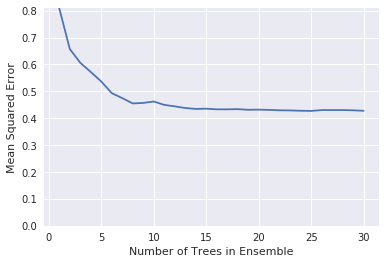

In [30]:
plt.plot(n_models, mse)
plt.axis('tight')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.ylim((0.0, max(mse)))
plt.show()

In [31]:
print(f'Minimum mse: {min(mse)}')

Minimum mse: 0.42716312699245634
